In [5]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.5 MB/s 
     |████████████████████████████████| 143 kB 27.4 MB/s 
     |████████████████████████████████| 180 kB 33.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a00db6efabbdabe05294bb60ca792a8866ea1446ab5787faa7512d7076f7169a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image

torch.cuda.is_available()

True

In [6]:
import wandb

wandb.init(project="old_image_reconstruction", entity="imsanskar", reinit=True)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import glob


class ImageDataset(Dataset):
    def __init__(self, old_image_path:str, reconstructed_image_path:str, transform = None):
        # set the transforms
        self.transform = transform
        self.old_image_path = old_image_path
        self.reconstructed_image_path = reconstructed_image_path
        
        # get all the file names 
        self.old_image_files = sorted(glob.glob(old_image_path + "/*.*"))
        self.reconstructed_image_files = sorted(glob.glob(reconstructed_image_path + "/*.*"))
        
    def __getitem__(self, index):
        reconstruted_image = Image.open(self.reconstructed_image_files[index % len(self.reconstructed_image_files)])
        old_image = Image.open(self.old_image_files[index % len(self.old_image_files)])
        
        if self.transform: 
            img_A = self.transform(old_image)
            img_B = self.transform(reconstruted_image)
        
        return {
            "A": img_A,
            "B": img_B
        }
    
    def __len__(self):
        return len(self.old_image_files)



In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import random
import cv2
from PIL import Image
import os
from io import BytesIO
from tqdm.notebook import tqdm, trange
import time

def blend_image(original_image: Image.Image, blend_image_source: Image.Image, intensity = 0.4):
    """
        Blends the original image with blend_image with intensity
    """
    
    # converts the blend_image to the format of original image
    # because both the image needs to be in the same format
    # same goes for size
    blend_image_source = blend_image_source.convert(original_image.mode) 
    blend_image_source = blend_image_source.resize(original_image.size)
    
    new_image = Image.new(original_image.mode, original_image.size)
    new_image = Image.blend(original_image, blend_image_source, intensity)
    
    return new_image


# In[3]:


def pil_to_np(img_pil):
    """
        Converts image from pil Image to numpy array
    """
    ar: np.ndarray = np.array(img_pil)
    if len(ar.shape) == 3:
        """
            Tensor transpose, since in this case tensor is 3D the order of transpose can be different
            In 2D matrix the transpose is only i,j-> j,i but in more than 2D matrix different permutation can be 
            applied
        """
        ar = ar.transpose(2, 0, 1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.


# In[4]:


def np_to_pil(img_np):
    """
        Converts np.ndarray to Image.Image object
    """
    ar = np.clip(img_np * 255, 0, 255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)


# In[5]:


def synthesize_salt_pepper(image: Image.Image, amount, salt_vs_pepper):
    """
        Salt and pepper noise is also known as an impulse noise, this noise can be caused by sharp and sudden 
        disturbances in the image signal. gives the appearance of scattered white or black(or both) pixel over
        the image
    """
    img_pil=pil_to_np(image)

    out = img_pil.copy()
    p = amount
    q = salt_vs_pepper
    flipped = np.random.choice([True, False], size=img_pil.shape,
                               p=[p, 1 - p])
    salted = np.random.choice([True, False], size=img_pil.shape,
                              p=[q, 1 - q])
    peppered = ~salted
    out[flipped & salted] = 1
    out[flipped & peppered] = 0.
    noisy = np.clip(out, 0, 1).astype(np.float32)
    return np_to_pil(noisy)


# In[6]:


def synthesize_speckle(image,std_l,std_r):

    ## Give PIL, return the noisy PIL

    img_pil=pil_to_np(image)

    mean=0
    std=random.uniform(std_l/255.,std_r/255.)
    gauss=np.random.normal(loc=mean,scale=std,size=img_pil.shape)
    noisy=img_pil+gauss*img_pil
    noisy=np.clip(noisy,0,1).astype(np.float32)

    return np_to_pil(noisy)


# In[7]:


def blur_image_v2(img):
    x=np.array(img)
    kernel_size_candidate=[(3,3),(5,5),(7,7)]
    kernel_size=random.sample(kernel_size_candidate,1)[0]
    std=random.uniform(1.,5.)

    #print("The gaussian kernel size: (%d,%d) std: %.2f"%(kernel_size[0],kernel_size[1],std))
    blur=cv2.GaussianBlur(x,kernel_size,std)

    return Image.fromarray(blur.astype(np.uint8))


# In[8]:


def synthesize_low_resolution(image: Image.Image):
    """
        Creates a low resolution image from high resolution image
    """
    width, height = image.size
    
    new_width = np.random.randint(int(width / 2), width - int(width / 5))
    new_height = np.random.randint(int(height / 2), height - int(height / 5))
    
    image = image.resize((new_width, new_height), Image.BICUBIC)
    
    if random.uniform(0, 1) < 0.5:
        image = image.resize((width, height), Image.NEAREST)
    else:
        image = image.resize((width, height), Image.BILINEAR)
        
    return image


# In[9]:


def online_add_degradation_v2(img):
    task_id = np.random.permutation(4)

    for x in task_id:
        if x == 0 and random.uniform(0,1)<0.7:
            img = blur_image_v2(img)
        if x == 1 and random.uniform(0,1)<0.7:
            flag = random.choice([1, 2, 3])
            if flag == 1:
                pass
                # img = synthesize_gaussian(img, 5, 50)
            if flag == 2:
                img = synthesize_speckle(img, 5, 50)
            if flag == 3:
                img = synthesize_salt_pepper(img, random.uniform(0, 0.01), random.uniform(0.3, 0.8))
        if x == 2 and random.uniform(0,1)<0.7:
            img=synthesize_low_resolution(img)

        if x==3 and random.uniform(0,1)<0.7:
            img=convertToJpeg(img,random.randint(40,100))

    return img


# In[10]:


def zero_mask(row, col):
    x = np.zeros((row, col, 3))
    mask=Image.fromarray(x).convert("RGB")
    return mask

def irregular_hole_synthesize(img, mask):
    """
        Create holes using scrach paper textures
        Args:
            img: Original Image
            mask: scratch paper texture
    """
    img_np = np.array(img).astype('uint8')
    mask = mask.resize(img.size)
    mask = mask.convert(img.mode) 
    mask_np = np.array(mask).astype('uint8')
    mask_np = mask_np / 255
    img_new=img_np * (1 - mask_np) + mask_np * 255


    hole_img=Image.fromarray(img_new.astype('uint8')).convert("RGB")


    return hole_img,mask.convert("L")


# In[11]:


def convertToJpeg(im,quality):
    with BytesIO() as f:
        im.save(f, format='JPEG',quality=quality)
        f.seek(0)
        return Image.open(f).convert('RGB')


# In[12]:



In [9]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [10]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 10

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [12]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [13]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [14]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [16]:
import torch.nn.functional as F
import math
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

## Model Train

In [17]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 10

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 512
image_width = 512


#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)



# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = ImageDataset(
    "drive/MyDrive/pix2pix/data/train_2/old_images", 
    "drive/MyDrive/pix2pix/data/train_2/reconstructed_images", 
    transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 10,
    shuffle = True
)

In [20]:
generator_error_file = "drive/MyDrive/pix2pix/generator_new_data.csv"
disc_error_file = "drive/MyDrive/pix2pix/discriminator_new_data.csv"

total_generator_epochs = 0
try: 
  with open(generator_error_file, "r") as f:
    last_line = None
    for last_line in f:
      pass
  if last_line != None:
    print("CSV file found")
    total_generator_epochs = int(last_line.split(',')[-1]) + 1
  else:
    total_generator_epochs = 0

  f.close()
except FileNotFoundError:
  with open(generator_error_file, "w") as f:
    total_generator_epochs = 0

  f.close()


total_discriminator_epochs = 0
try: 
  with open(disc_error_file, "r") as f:
    last_line = None
    for last_line in f:
      pass
  if last_line != None:
    total_discriminator_epochs = int(last_line.split(',')[-1]) + 1
    print(f"CSV file found: {total_discriminator_epochs}")
  else:
    total_discriminator_epochs = 0

  f.close()
except FileNotFoundError:
  with open(disc_error_file, "w") as f:
    total_generator_epochs = 0

  f.close()

generator_file = f"drive/MyDrive/pix2pix/saved_models_new_data/generator_{total_generator_epochs - 1}.pth"
discriminator_file = f"drive/MyDrive/pix2pix/saved_models_new_data/discriminator_{total_generator_epochs - 1}.pth"
# initialize weights if the model is not found in the paths
if os.path.exists(generator_file):
  print("Generator Found")
  generator.load_state_dict(torch.load(generator_file, map_location = device))
else:
  generator.apply(weights_init_normal)


if os.path.exists(discriminator_file):
  print("Discriminator Found")
  discriminator.load_state_dict(torch.load(discriminator_file, map_location = device))
else:
  discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)

# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)


CSV file found
CSV file found: 50
Generator Found
Discriminator Found


In [ ]:
generator_validate = GeneratorUNet()
discriminator_validate = Discriminator()
# to cuda if cuda is avaiable
generator_validate.to(device)
discriminator_validate.to(device)



for epoch in range(20):
    loss_G_list = np.array([])
    loss_D_list = np.array([])
    loss_pixelwise_list = np.array([])
    loss_mse_list = np.array([])
    loss_G_list_validate = np.array([])
    loss_D_list_validate = np.array([]) 
    loss_pixelwise_list_validate = np.array([])
    loss_ssim_list_validate = np.array([])



    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #---------------------------------- TRAINING ------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # toal loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()

        loss_G_list = np.append(loss_G_list,  torch.linalg.norm(loss_G).item())
        loss_D_list = np.append(loss_D_list,  torch.linalg.norm(loss_D).item())
        loss_pixelwise_list = np.append(loss_pixelwise_list,  torch.linalg.norm(loss_pixel).item())
        loss_mse_list = np.append(loss_mse_list,  torch.linalg.norm(loss_generator).item())
        loss_ssim_list_validate = np.append(loss_ssim_list_validate,  ssim(fake_B.detach().cpu(), list(iter(real_B))[0].unsqueeze(0).detach().cpu(), 225)) 

        # for logging
        if i % 10 == 0 and i:
            print(f"Error Generator: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
            print(f"Error Discriminator: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")

            
    torch.save(generator.state_dict(), f"drive/MyDrive/pix2pix/saved_models_new_data/generator_{epoch + total_generator_epochs}.pth")
    torch.save(discriminator.state_dict(), f"drive/MyDrive/pix2pix/saved_models_new_data/discriminator_{epoch + total_discriminator_epochs}.pth")
    print("Generator saved \n Discriminator Saved \n")
    with open(f"{generator_error_file}", "a") as f:
      f.write(f"Error Generator, {np.mean(loss_G_list)}, {epoch + total_generator_epochs}")

    
    with open(f"{disc_error_file}", "a") as f:
      f.write(f"Error Generator, {np.mean(loss_D_list)}, {epoch + total_discriminator_epochs}")



    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #---------------------------------- VALIDATION -------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------


    # initialize weights if the model is not found in the paths
    # if os.path.exists(f"drive/MyDrive/saved_models/generator_{epoch}.pth"):
    #     generator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/generator_{epoch}.pth", map_location = device))
    # else:
    #     generator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/generator.pth", map_location = device))
                                          
    # if os.path.exists(f"drive/MyDrive/saved_models/discriminator_{epoch}.pth"):
    #     discriminator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/discriminator_{epoch}.pth", map_location = device))
    # else:
    #     generator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/generator.pth", map_location = device))
    
    # i = 1
    # while i <= 10:
    #     index = np.random.randint(1000 + 10 * i, 1000 + 10 * (i + 1))
    #     batch = pair_image_dataloader[index]
    #     real_A = batch['A'].unsqueeze(0) # old image
    #     real_B = batch['B'].unsqueeze(0) # new image
        
    #     # Adversarial ground truths
    #     valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
    #     fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
    #     # GAN loss
    #     fake_B = generator_validate(real_A.to(device)) # fake sample generated by generator
    #     pred_fake = discriminator_validate(fake_B.to(device), real_B.to(device)) # prediction using discriminator_validate
    #     loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
    #     loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
    #     # total loss
    #     loss_G = loss_generator + lambda_pixel * loss_pixel # toal loss of the generator
        
    #     # Real loss
    #     pred_real = discriminator_validate(real_B.to(device), real_A.to(device)) # loss to check real or not
    #     loss_real = loss_fn_generator(pred_real, valid)

    #     # Fake loss
    #     pred_fake = discriminator_validate(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
    #     loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

    #     # Total loss
    #     loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator_validate

    #     loss_G_list_validate = np.append(loss_G_list_validate,  torch.linalg.norm(loss_G).item())
    #     loss_D_list_validate = np.append(loss_D_list_validate,  torch.linalg.norm(loss_D).item())
    #     loss_pixelwise_list_validate = np.append(loss_pixelwise_list_validate,  torch.linalg.norm(loss_pixel).item())
    #     loss_mse_list_validate = np.append(loss_mse_list_validate,  torch.linalg.norm(loss_generator).item())        

    #     # for logging
    #     if i % 10 == 0 and i:
    #         print(f"Error Generator Validation: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
    #         print(f"Error Discriminator Validation: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")

    #     i += 1

            
    wandb.log({
        'Generator loss_true': np.mean(loss_G_list),
        'Discriminator loss_true': np.mean(loss_D_list),
        'Pixel Loss_true': np.mean(loss_pixelwise_list),
        'MSE Loss_true': np.mean(loss_mse_list),
        'SSIM loss_validate': np.mean(loss_ssim_list_validate),
        # 'Discriminator loss_validate': np.mean(loss_D_list_validate),
        # 'Pixel Loss_validate': np.mean(loss_pixelwise_list_validate),
        # 'MSE Loss_validate': np.mean(loss_mse_list_validate)
    })


0it [00:00, ?it/s]

Error Generator: 6.634239196777344, epoch: 0, itr: 10
Error Discriminator: 0.0011673958506435156, epoch: 0, itr: 10
Error Generator: 8.49375057220459, epoch: 0, itr: 20
Error Discriminator: 4.745916157844476e-06, epoch: 0, itr: 20
Error Generator: 6.2821831703186035, epoch: 0, itr: 30
Error Discriminator: 0.0012614504666998982, epoch: 0, itr: 30
Error Generator: 7.3916192054748535, epoch: 0, itr: 40
Error Discriminator: 0.013188286684453487, epoch: 0, itr: 40
Error Generator: 7.200387477874756, epoch: 0, itr: 50
Error Discriminator: 4.269013152224943e-05, epoch: 0, itr: 50
Error Generator: 5.661628246307373, epoch: 0, itr: 60
Error Discriminator: 0.005223952233791351, epoch: 0, itr: 60
Error Generator: 6.8401713371276855, epoch: 0, itr: 70
Error Discriminator: 4.7957306378521025e-05, epoch: 0, itr: 70
Error Generator: 5.73893928527832, epoch: 0, itr: 80
Error Discriminator: 1.2990396498935297e-05, epoch: 0, itr: 80
Error Generator: 5.7793474197387695, epoch: 0, itr: 90
Error Discrimina

0it [00:00, ?it/s]

Error Generator: 7.364874839782715, epoch: 1, itr: 10
Error Discriminator: 8.472587978758384e-06, epoch: 1, itr: 10
Error Generator: 5.405993461608887, epoch: 1, itr: 20
Error Discriminator: 1.8716695194598287e-05, epoch: 1, itr: 20
Error Generator: 6.03593111038208, epoch: 1, itr: 30
Error Discriminator: 3.161666973028332e-05, epoch: 1, itr: 30
Error Generator: 6.88731050491333, epoch: 1, itr: 40
Error Discriminator: 2.0475265500863316e-06, epoch: 1, itr: 40
Error Generator: 7.46990442276001, epoch: 1, itr: 50
Error Discriminator: 0.0008364582899957895, epoch: 1, itr: 50
Error Generator: 6.056776523590088, epoch: 1, itr: 60
Error Discriminator: 0.00011937069211853668, epoch: 1, itr: 60
Error Generator: 5.827422142028809, epoch: 1, itr: 70
Error Discriminator: 3.593054134398699e-05, epoch: 1, itr: 70
Error Generator: 6.733006954193115, epoch: 1, itr: 80
Error Discriminator: 5.0925969844684005e-05, epoch: 1, itr: 80
Error Generator: 5.7024102210998535, epoch: 1, itr: 90
Error Discrimina

0it [00:00, ?it/s]

Error Generator: 5.371368885040283, epoch: 2, itr: 10
Error Discriminator: 5.003467776987236e-06, epoch: 2, itr: 10
Error Generator: 5.322618007659912, epoch: 2, itr: 20
Error Discriminator: 2.048255737463478e-06, epoch: 2, itr: 20
Error Generator: 9.673500061035156, epoch: 2, itr: 30
Error Discriminator: 2.865776332328096e-05, epoch: 2, itr: 30
Error Generator: 7.666563034057617, epoch: 2, itr: 40
Error Discriminator: 1.1139949492644519e-05, epoch: 2, itr: 40
Error Generator: 6.070559024810791, epoch: 2, itr: 50
Error Discriminator: 6.610957370867254e-06, epoch: 2, itr: 50
Error Generator: 7.790696144104004, epoch: 2, itr: 60
Error Discriminator: 0.00024174679128918797, epoch: 2, itr: 60
Error Generator: 6.624932765960693, epoch: 2, itr: 70
Error Discriminator: 2.483861317159608e-05, epoch: 2, itr: 70
Error Generator: 6.106126308441162, epoch: 2, itr: 80
Error Discriminator: 0.0007513972814194858, epoch: 2, itr: 80
Error Generator: 6.928081035614014, epoch: 2, itr: 90
Error Discrimina

0it [00:00, ?it/s]

Error Generator: 5.741778373718262, epoch: 3, itr: 10
Error Discriminator: 0.0002830649318639189, epoch: 3, itr: 10
Error Generator: 5.814854145050049, epoch: 3, itr: 20
Error Discriminator: 8.45760132506257e-06, epoch: 3, itr: 20
Error Generator: 5.171874046325684, epoch: 3, itr: 30
Error Discriminator: 0.0012163277715444565, epoch: 3, itr: 30
Error Generator: 6.84970235824585, epoch: 3, itr: 40
Error Discriminator: 1.6618760128039867e-05, epoch: 3, itr: 40
Error Generator: 5.640869140625, epoch: 3, itr: 50
Error Discriminator: 3.2002712941903155e-06, epoch: 3, itr: 50
Error Generator: 5.502610206604004, epoch: 3, itr: 60
Error Discriminator: 1.403981150360778e-05, epoch: 3, itr: 60
Error Generator: 5.607918739318848, epoch: 3, itr: 70
Error Discriminator: 2.8048334570485167e-06, epoch: 3, itr: 70
Error Generator: 5.781834602355957, epoch: 3, itr: 80
Error Discriminator: 0.00018975646526087075, epoch: 3, itr: 80
Error Generator: 6.8052897453308105, epoch: 3, itr: 90
Error Discriminato

0it [00:00, ?it/s]

Error Generator: 5.830915451049805, epoch: 4, itr: 10
Error Discriminator: 3.3073868053179467e-06, epoch: 4, itr: 10
Error Generator: 6.350175380706787, epoch: 4, itr: 20
Error Discriminator: 4.076281584275421e-06, epoch: 4, itr: 20
Error Generator: 5.788851261138916, epoch: 4, itr: 30
Error Discriminator: 1.872820803328068e-06, epoch: 4, itr: 30
Error Generator: 4.634765148162842, epoch: 4, itr: 40
Error Discriminator: 1.6981926819426008e-05, epoch: 4, itr: 40
Error Generator: 6.262068271636963, epoch: 4, itr: 50
Error Discriminator: 5.7697029660630506e-06, epoch: 4, itr: 50
Error Generator: 5.350370407104492, epoch: 4, itr: 60
Error Discriminator: 5.5447300837840885e-05, epoch: 4, itr: 60
Error Generator: 5.43214225769043, epoch: 4, itr: 70
Error Discriminator: 4.064217137056403e-06, epoch: 4, itr: 70
Error Generator: 5.443653106689453, epoch: 4, itr: 80
Error Discriminator: 2.368478999414947e-05, epoch: 4, itr: 80
Error Generator: 5.440551280975342, epoch: 4, itr: 90
Error Discrimin

0it [00:00, ?it/s]

Error Generator: 6.493838787078857, epoch: 5, itr: 10
Error Discriminator: 4.923669621348381e-06, epoch: 5, itr: 10
Error Generator: 5.751712799072266, epoch: 5, itr: 20
Error Discriminator: 1.4311719951365376e-06, epoch: 5, itr: 20
Error Generator: 5.677943706512451, epoch: 5, itr: 30
Error Discriminator: 5.027243241784163e-05, epoch: 5, itr: 30
Error Generator: 5.8473687171936035, epoch: 5, itr: 40
Error Discriminator: 2.610536967040389e-06, epoch: 5, itr: 40
Error Generator: 5.843560695648193, epoch: 5, itr: 50
Error Discriminator: 0.0006437035044655204, epoch: 5, itr: 50
Error Generator: 6.762705326080322, epoch: 5, itr: 60
Error Discriminator: 1.2565861879920703e-06, epoch: 5, itr: 60
Error Generator: 5.237173080444336, epoch: 5, itr: 70
Error Discriminator: 8.927163435146213e-07, epoch: 5, itr: 70
Error Generator: 5.239875793457031, epoch: 5, itr: 80
Error Discriminator: 5.640397375827888e-06, epoch: 5, itr: 80
Error Generator: 5.976617813110352, epoch: 5, itr: 90
Error Discrimin

0it [00:00, ?it/s]

Error Generator: 7.883816719055176, epoch: 6, itr: 10
Error Discriminator: 2.918578957178397e-06, epoch: 6, itr: 10
Error Generator: 5.620337009429932, epoch: 6, itr: 20
Error Discriminator: 1.2335970041021938e-06, epoch: 6, itr: 20
Error Generator: 5.874702453613281, epoch: 6, itr: 30
Error Discriminator: 3.913759883289458e-06, epoch: 6, itr: 30
Error Generator: 7.13996696472168, epoch: 6, itr: 40
Error Discriminator: 5.785332177765667e-07, epoch: 6, itr: 40
Error Generator: 5.6263813972473145, epoch: 6, itr: 50
Error Discriminator: 2.4461435259581776e-06, epoch: 6, itr: 50
Error Generator: 6.106389045715332, epoch: 6, itr: 60
Error Discriminator: 5.079393304185942e-06, epoch: 6, itr: 60
Error Generator: 6.0385050773620605, epoch: 6, itr: 70
Error Discriminator: 2.3321576918533538e-06, epoch: 6, itr: 70
Error Generator: 5.249199390411377, epoch: 6, itr: 80
Error Discriminator: 2.2020698452251963e-05, epoch: 6, itr: 80
Error Generator: 5.479351043701172, epoch: 6, itr: 90
Error Discrim

0it [00:00, ?it/s]

Error Generator: 5.625942230224609, epoch: 7, itr: 10
Error Discriminator: 4.525707936409162e-06, epoch: 7, itr: 10
Error Generator: 5.216888904571533, epoch: 7, itr: 20
Error Discriminator: 4.272296337148873e-06, epoch: 7, itr: 20
Error Generator: 5.682308673858643, epoch: 7, itr: 30
Error Discriminator: 4.884654117631726e-06, epoch: 7, itr: 30
Error Generator: 6.064913272857666, epoch: 7, itr: 40
Error Discriminator: 3.72625004274596e-06, epoch: 7, itr: 40
Error Generator: 6.407260894775391, epoch: 7, itr: 50
Error Discriminator: 3.221009137632791e-06, epoch: 7, itr: 50
Error Generator: 5.226551532745361, epoch: 7, itr: 60
Error Discriminator: 4.98084682476474e-06, epoch: 7, itr: 60
Error Generator: 7.27808141708374, epoch: 7, itr: 70
Error Discriminator: 1.810800313251093e-05, epoch: 7, itr: 70
Error Generator: 5.2026214599609375, epoch: 7, itr: 80
Error Discriminator: 1.7710219253785908e-05, epoch: 7, itr: 80
Error Generator: 6.1314802169799805, epoch: 7, itr: 90
Error Discriminato

0it [00:00, ?it/s]

Error Generator: 5.641882419586182, epoch: 8, itr: 10
Error Discriminator: 4.1522609535604715e-05, epoch: 8, itr: 10
Error Generator: 5.824635028839111, epoch: 8, itr: 20
Error Discriminator: 1.2210367458465043e-05, epoch: 8, itr: 20
Error Generator: 5.110318660736084, epoch: 8, itr: 30
Error Discriminator: 1.770654125721194e-05, epoch: 8, itr: 30
Error Generator: 6.662595748901367, epoch: 8, itr: 40
Error Discriminator: 7.333518169616582e-06, epoch: 8, itr: 40
Error Generator: 5.452813148498535, epoch: 8, itr: 50
Error Discriminator: 0.0008582533919252455, epoch: 8, itr: 50
Error Generator: 5.305549144744873, epoch: 8, itr: 60
Error Discriminator: 3.499886588542722e-05, epoch: 8, itr: 60
Error Generator: 5.952116012573242, epoch: 8, itr: 70
Error Discriminator: 9.749291348271072e-05, epoch: 8, itr: 70
Error Generator: 6.435283660888672, epoch: 8, itr: 80
Error Discriminator: 2.6311532565159723e-05, epoch: 8, itr: 80
Error Generator: 6.711206436157227, epoch: 8, itr: 90
Error Discrimin

0it [00:00, ?it/s]

Error Generator: 8.011749267578125, epoch: 9, itr: 10
Error Discriminator: 0.0001845125516410917, epoch: 9, itr: 10
Error Generator: 4.885588645935059, epoch: 9, itr: 20
Error Discriminator: 2.1991152607370168e-05, epoch: 9, itr: 20
Error Generator: 5.983348846435547, epoch: 9, itr: 30
Error Discriminator: 5.088107718620449e-05, epoch: 9, itr: 30
Error Generator: 5.201571941375732, epoch: 9, itr: 40
Error Discriminator: 7.536800694651902e-05, epoch: 9, itr: 40
Error Generator: 5.5305070877075195, epoch: 9, itr: 50
Error Discriminator: 0.0004963231040164828, epoch: 9, itr: 50
Error Generator: 5.270599842071533, epoch: 9, itr: 60
Error Discriminator: 0.006889353506267071, epoch: 9, itr: 60
Error Generator: 5.801597595214844, epoch: 9, itr: 70
Error Discriminator: 0.00084139738464728, epoch: 9, itr: 70
Error Generator: 5.005519866943359, epoch: 9, itr: 80
Error Discriminator: 0.0003382951545063406, epoch: 9, itr: 80
Error Generator: 5.966679573059082, epoch: 9, itr: 90
Error Discriminator

0it [00:00, ?it/s]

In [ ]:
generator_validate = GeneratorUNet()
discriminator_validate = Discriminator()
generator_validate.eval()
discriminator_validate.eval()
for epoch in range(50):
    loss_G_list = np.array([])
    loss_D_list = np.array([])
    loss_pixelwise_list = np.array([])
    loss_mse_list = np.array([])

      # initialize weights if the model is not found in the paths
    if os.path.exists(f"drive/MyDrive/Minor/webpage/dl_model/saved_models/generator_{epoch}.pth"):
        generator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/generator_{epoch}.pth", map_location = device))
    else:
        generator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/generator.pth", map_location = device))
                                          
    if os.path.exists(f"drive/MyDrive/saved_models/discriminator_{epoch}.pth"):
        discriminator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/discriminator_{epoch}.pth", map_location = device))
    else:
        generator_validate.load_state_dict(torch.load(f"drive/MyDrive/saved_models/generator.pth", map_location = device))
    
    i = 1
    while i <= 100:
        index = np.random.randint(1000 + 10 * i, 1000 + 10 * (i + 1))
        batch = pair_image_dataloader[index]
        real_A = batch['A'].unsqueeze(0) # old image
        real_B = batch['B'].unsqueeze(0) # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # toal loss of the generator
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator

        loss_G_list = np.append(loss_G_list,  torch.linalg.norm(loss_G).item())
        loss_D_list = np.append(loss_D_list,  torch.linalg.norm(loss_D).item())
        loss_pixelwise_list = np.append(loss_pixelwise_list,  torch.linalg.norm(loss_pixel).item())
        loss_mse_list = np.append(loss_mse_list,  torch.linalg.norm(loss_generator).item())        

        # for logging
        if i % 10 == 0 and i:
            print(f"Error Generator: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
            print(f"Error Discriminator: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")

        i += 1

            
    wandb.log({
        'Generator loss_validate': np.mean(loss_G_list),
        'Discriminator loss_validate': np.mean(loss_D_list),
        'Pixel Loss_validate': np.mean(loss_pixelwise_list),
        'MSE Loss_validate': np.mean(loss_mse_list)
    })

KeyboardInterrupt: ignored

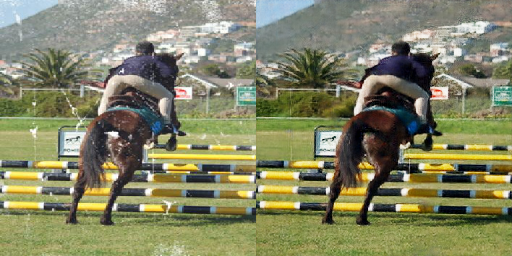

In [ ]:
test_image_index = 9
output_image = np_to_pil(
    generator(pair_image_dataloader[test_image_index]['A'].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = np_to_pil(
    pair_image_dataloader[test_image_index]['A'].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image

In [ ]:
torch.save(generator.state_dict(), "drive/MyDrive/saved_models/generator.pth")
torch.save(discriminator.state_dict(), "drive/MyDrive/saved_models/discriminator.pth")

In [ ]:
wandb.run.name = wandb.run.id
wandb.run.save()

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True